In [30]:
import pandas as pd
from io import StringIO
import os
import numpy as np
import matplotlib.pyplot as plt

In [31]:
# bw = "100mbps"

In [32]:
results = {}

In [33]:
def read_trace(trace_dir, trace_file, worker_id=None):
    trace_filepath = os.path.join(trace_dir, trace_file)
    
    with open(trace_filepath,"r") as rf:
        new_trace = StringIO()
        line = rf.readline()
        while line:
            line_list = line.split()
            if line_list[0] == "[trace]" or line_list[0] == "[PROF]":
                new_trace.write(line)
            line = rf.readline()
       
    new_trace.seek(0)
    df = pd.read_csv(new_trace, sep=" ", names=["InfoType", "EventType", "EventState", "ID", "Time"])
    del df["InfoType"]
    
    if worker_id is not None:
        df.insert(0, "WorkerID", worker_id)
        
    new_trace.close()
    
    return df

## vm1-vm2

In [34]:
dir_id = "vm1-vm2"
p_size_list = ["10000", "5000000", "10000000"]
message_size_list = []
avg_recv_ratio_list = []
avg_duration_list = []

for p_size in p_size_list:
    recv_ratio_list = []
    trace_dir = "/home/posheng/billy_ws/fl_025/fl_experiment_trace/nchc/send_bench/" + dir_id
    coord_trace_file = "coord_" + p_size + ".txt"
    
    coord_df = read_trace(trace_dir, coord_trace_file)
    coord_df = coord_df[4:].reset_index()
    del coord_df["index"]
    
    avg_duration = coord_df[coord_df["EventType"] == "ModelSend"][1:]["Time"].mean()
    avg_duration_list.append(avg_duration)
    
    start_indices = list(coord_df[coord_df["EventType"] == "MessageSize"].index)
    for start_index in start_indices:
        message_size = int(coord_df.loc[start_index]["EventState"])
        send_time = coord_df.loc[start_index+2]["Time"] - coord_df.loc[start_index+1]["Time"]
        recv_time = coord_df.loc[start_index+3]["Time"] - coord_df.loc[start_index+2]["Time"]
        recv_ratio = recv_time / (send_time + recv_time)
        recv_ratio_list.append(recv_ratio)
    
    message_size_list.append(message_size)
    avg_recv_ratio = sum(recv_ratio_list) / len(recv_ratio_list)
    avg_recv_ratio_list.append(avg_recv_ratio)

In [35]:
message_size_list

[123280, 60007874, 120011186]

In [36]:
avg_recv_ratio_list

[0.9835647192183921, 0.9562178940006673, 0.8945339935965093]

In [37]:
avg_duration_list

[0.018225085735321046, 7.364577639102936, 15.892740988731385]

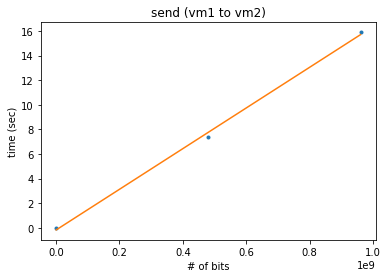

In [38]:
index_list = [int(message_size)*8 for message_size in message_size_list]
z2 = np.polyfit(index_list, avg_duration_list, 1)
p2 = np.poly1d(z2)
xp = np.linspace(index_list[0], index_list[-1], 1000)

plt.title('send (vm1 to vm2)')
plt.xlabel('# of bits')
plt.ylabel('time (sec)')
plt.plot(index_list, avg_duration_list, '.', xp, p2(xp))

In [39]:
1/z2[0] / 1000 / 1000

60.41633013437355

In [40]:
message_size_list

[123280, 60007874, 120011186]

In [41]:
p_size_list = ["10000", "5000000", "10000000"]

avg_recv_ratio_list = []
avg_duration_list = []

for p_size in p_size_list:
    trace_dir = "/home/posheng/billy_ws/fl_025/fl_experiment_trace/nchc/get_bench"
    coord_trace_file = "coord_" + p_size + ".txt"

    coord_df = read_trace(trace_dir, coord_trace_file)
    coord_df = coord_df[4:].reset_index()  
    del coord_df["index"]

    avg_duration = coord_df[coord_df["EventType"] == "GetTime"][1:]["Time"].mean()
    avg_duration_list.append(avg_duration)

In [42]:
avg_duration_list

[0.0034865736961364746, 0.46815510988235476, 1.1303132772445679]

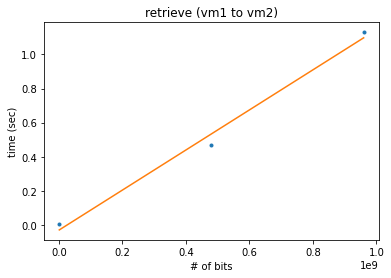

In [43]:
index_list = [int(message_size)*8 for message_size in message_size_list]
z2 = np.polyfit(index_list, avg_duration_list, 1)
p2 = np.poly1d(z2)
xp = np.linspace(index_list[0], index_list[-1], 1000)

plt.title('retrieve (vm1 to vm2)')
plt.xlabel('# of bits')
plt.ylabel('time (sec)')
plt.plot(index_list, avg_duration_list, '.', xp, p2(xp))

In [44]:
1/z2[0] / 1000 / 1000

851.1052117080615